<img src = '../images/20191018214303.png'>

- 回帰：燃費を予測する https://www.tensorflow.org/tutorials/keras/regression?hl=ja
- 機械学習の歴史　https://www.jstage.jst.go.jp/article/psychono/35/2/35_35.26/_pdf　...画像認識においてNNがSVMの精度を超えたのは2012年。このとき使われたNNがCNN。2016年，Googleが買収したスタートアップDeepMind社のAlphaGoが人間の囲碁世界王者を破った。AlphaGoは碁盤の局面認識に深層ニューラルネットワークを用い，強化学習とモンテカルロ木探索(Monte Carlo tree search)を組み合わせている(Silver et al.,2016)。
- ML全般　http://www.ms.k.u-tokyo.ac.jp/research-jp.html
- NNについてのわかりやすい解説（回帰は他の資料も見る必要がある）https://qiita.com/Nezura/items/0a37e1746f2830e31ddc
- 活性化関数まとめhttps://qiita.com/namitop/items/d3d5091c7d0ab669195f

#### 特徴量選択に関係しそうな論文
- いいサイト　IEEE Geoscience and Remote Sensing Letters
- Layerwise feature selection in Stacked Sparse Auto-Encoder for tumor type prediction ~2016 IEEE International Conference on Bioinformatics and Biomedicine (BIBM)  ~Year: 2016, Volume: 1, Pages: 1542-1548  DOI Bookmark:10.1109/BIBM.2016.7822750
- Large-Scale Empirical Study of Important Features Indicative of Discovered Vulnerabilities to Assess Application Security  ~Mengyuan Zhang
- Automatic lung nodule detection using multi-scale dot nodule-enhancement filter and weighted support vector machines in chest computed tomography  ~Yu Gu https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0210551

### 1. NN

- 誤差逆伝播則は，正解との差異，すなわち誤差の自乗和を，シナプス結合強度で微分し，各結合強度で加重して下位層へ伝播させる。誤差逆伝播則は入力層と出力層だけでなく，中間層を許す。このため，入出力の表象に拘束されない内部表象を獲得することが期待される。
- オートエンコーダはノイズ除去、次元削減などに有効なネットワークだ。その名の通り、入力データを再現（デコード）することが可能な低次元の特徴を抽出（エンコード）できる。中間層は全結合である必要はなく、数十層重ねることが多い。積層型オートエンコーダ（Stacked Autoencoder）は、中間層のエンコード部分を一層ずつ逐次的に加えて学習し、積み重ねていく。教師なし学習のため、入力データ自身を教師データとするところが、ここまで紹介した他のネットワークとは異なる点だ。

In [1]:
# 隠れ層をfitメソッドで指定できるように作りました。
# 重みの更新はtrain_stepで指定したOptimizerによるコスト関数最小化で行ってくれるので、
# バックプロパゲーションを手動で構築する必要はありません。
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class nnet:
    def __init__(self, X, random_state=3):
        self.sess = tf.Session()
        seed = random_state
        tf.set_random_seed(seed)
        np.random.seed(seed)
        self.x_data = tf.placeholder(shape=[None, X.shape[1]], dtype=tf.float32)
        self.y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

    def init_weight(self, shape, st_dev):
        return tf.Variable(tf.random_normal(shape, stddev=st_dev))

    def init_bias(self, shape, st_dev):
        return tf.Variable(tf.random_normal(shape, stddev=st_dev))

    def fully_connected(self, input_layer, weights, biases):
        return tf.nn.relu(tf.add(tf.matmul(input_layer, weights), biases))

    def fit(self, X, y, hidden_size, batch_size=100, iter_size=200):

        x_data = self.x_data
        y_target = self.y_target

        final_output = self.build_hidden_layer(hidden_size, X.shape[1])

        self.loss = tf.reduce_mean(tf.abs(y_target - final_output))
        self.opt = tf.train.AdamOptimizer(0.05)
        self.train_step = self.opt.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

        loss_vec = self.train(X, y, iter_size, batch_size)
        plt.plot(loss_vec)
        return final_output

    def predict(self, final_output, X):
        x_data = self.x_data
        return [val[0] for val in self.sess.run(final_output, feed_dict={x_data: X})]


    def train(self, X, y, iter_size, batch_size):
        loss_vec = []
        x_data = self.x_data
        y_target = self.y_target
        for i in range(iter_size):
            rand_index = np.random.choice(len(X), size=batch_size)
            rand_x = X[rand_index]
            rand_y = np.transpose([y[rand_index]])
            self.sess.run(self.train_step, feed_dict={x_data:rand_x, y_target: rand_y})
            loss_vec.append(self.sess.run(self.loss, feed_dict={x_data:rand_x, y_target: rand_y}))

            if (i+1)%25==0:
                print('Generation:'+str(i+1)+', Loss = '+str(loss_vec[-1]))

        return loss_vec


# input_sizeは、画像のピクセル数をならしたもの28*28、
# hidden_sizeは隠れ層のニューロン、
# output_size=10は、0~９までの数字を想定
    def build_hidden_layer(self, hidden_size, col_size):
        weights = []
        biases = []
        layers = []
        tmp_size = col_size
        x_data = self.x_data
        last_layer = x_data

        for hsize in hidden_size:
            weights.append(self.init_weight(shape=[tmp_size, hsize], st_dev=10.0))
            biases.append(self.init_bias(shape=[hsize], st_dev=10.0))
            layers.append(self.fully_connected(last_layer, weights[-1], biases[-1]))
            tmp_size = hsize
            last_layer = layers[-1]

        weights.append(self.init_weight(shape=[tmp_size, 1], st_dev=10.0))
        biases.append(self.init_bias(shape=[1], st_dev=10.0))
        layers.append(self.fully_connected(last_layer, weights[-1], biases[-1]))
        final_output = layers[-1]

        return final_output

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/Caskroom/miniconda/base/lib/python3

In [3]:
import requests
import csv
import os

birthdata_url = 'https://raw.githubusercontent.com/nfmcclure/tensorflow_cookbook/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
birth_file = requests.get(birthdata_url)
birth_data = birth_file.text.split('\r\n')
birth_header = birth_data[0].split('\t')
birth_data = [[float(x) for x in y.split('\t') if len(x) >= 1]  
              for y in birth_data[1:] if len(y) >= 1]

with open("birth_weight.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows([birth_header])
    writer.writerows(birth_data)
    f.close()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return np.nan_to_num((m-col_min)/(col_max-col_min))

df = pd.read_csv("birth_weight.csv")
target_name = ["BWT"]
X, y = df[df.columns.drop(target_name)], df[target_name]
X, y = X.as_matrix(), y.as_matrix()
X = normalize_cols(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


Generation:25, Loss = 7338.214
Generation:50, Loss = 2569.9954
Generation:75, Loss = 2654.5986
Generation:100, Loss = 2608.3584
Generation:125, Loss = 2320.6992
Generation:150, Loss = 2276.543
Generation:175, Loss = 2016.3213
Generation:200, Loss = 1857.8002


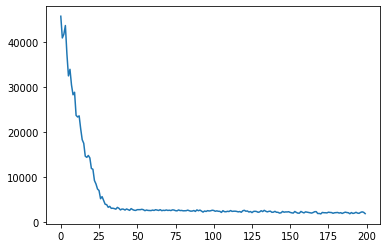

In [5]:
%matplotlib inline
nnetc = nnet(X_train)
model = nnetc.fit(X_train, y_train.ravel(), hidden_size=[25, 10, 3], iter_size=200)
# 25からスタートして25ずつ増やしている
#hidden_size（一般）...隠れ層の数

In [6]:
from sklearn.metrics import confusion_matrix
preds = nnetc.predict(model, X_test)
preds_binary = np.array([1.0 if val<3000.0 else 0.0 for val in preds])
y_test_binary = np.array([1.0 if val<3000.0 else 0.0 for val in y_test.ravel()])

confusion_matrix(y_test_binary, preds_binary)

array([[ 9, 16],
       [ 5, 18]])